In [35]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from __future__ import print_function
from scipy.signal import savgol_filter
import sklearn.metrics
import random

from scipy import stats
from sklearn.model_selection import KFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

### Utility Functions

In [36]:
######### Standardization #########
def df_std(csv):
    mean = csv.values.mean()
    std = csv.values.std()
    return (csv - mean)/std

def df_std_bycol(csv):
    df_std_bycol = pd.DataFrame(columns=csv.columns)
    for i in csv.columns:
        mean = csv[i].mean()
        std = csv[i].std()
        df_std_bycol[i] = (csv[i]-mean)/std
    return df_std_bycol

def df_unstd_bycol(csv_OG, csv):
    df_unstd_bycol = pd.DataFrame(columns=csv.columns)
    for i in csv.columns:
        mean = csv_OG[i].mean()
        std = csv_OG[i].std()
        df_unstd_bycol[i] = (csv[i]*std) + mean
    return df_unstd_bycol    

def val_df_std(csv, val):
    mean = csv.values.mean()
    std = csv.values.std()
    return (val - mean)/std

def val_df_std_bycol(csv,val):
    df_std_bycol = pd.DataFrame(columns=csv.columns)
    for i in csv.columns:
        mean = csv[i].mean()
        std = csv[i].std()
        df_std_bycol[i] = (val[i]-mean)/std
    return df_std_bycol

def val_df_unstd_bycol(csv_OG, csv):
    df_unstd_bycol = pd.DataFrame(columns=csv.columns)
    for i in csv.columns:
        mean = csv_OG[i].mean()
        std = csv_OG[i].std()
        df_unstd_bycol[i] = (csv[i]*std) + mean
    return df_unstd_bycol    

######### K-fold validation #########
def split(df): 
    idx_list = list(df.index - 1)
    random.shuffle(idx_list) 

    train_list = idx_list[:int(np.round(len(idx_list)*0.8))]
    val_list = idx_list[int(np.round(len(idx_list)*0.8)):]

    df1 = df.iloc[train_list,:]
    df2 = df.iloc[val_list,:]
    
    return train_list, val_list

def sub_df(df, train_list, val_list):
    df1 = df.iloc[train_list,:]
    df2 = df.iloc[val_list,:] 
    
    return df1, df2 

folds = 6
def kfold(df):
    kf = KFold(n_splits=folds, shuffle=True, random_state=0)
    return kf.split(df)

### Read in features, standardize everything, and concatenate into one big "barcode"

In [37]:
######### Take in dataframes #########
pathcsv_fmax = './train/df_fmax.csv'
pathcsv_min = './train/df_Min.csv'
pathcsv_skew = './train/df_Skewness.csv'
pathcsv_conc = './train/conditions_metalconcentrations.csv'

df_fmax = pd.read_csv(pathcsv_fmax, header=0, index_col=0)
df_min = pd.read_csv(pathcsv_min, header=0, index_col=0)
df_skew = pd.read_csv(pathcsv_skew, header=0, index_col=0)
df_conc = pd.read_csv(pathcsv_conc, header=0, index_col=0)

######### Standardize #########
df_fmax_std = df_std(df_fmax)
df_conc_std = df_std_bycol(df_conc)
df_min_std = df_std(df_min)
df_skew_std = df_std(df_skew)

######### Concatenate dataframes into 'barcode' #########
HMs = ['Hg', 'Pb', 'As', 'Cd', 'Cu']
strains = list(range(0,15,1))
feats = ['fmax', 'min', 'skew']
dfs = [df_fmax_std, df_min_std,  df_skew_std]


n=0
for i in feats:
    feat_col = []
    for j in strains: 
        feat_col.append(i+'_'+str(j))
    dfs[n].columns = feat_col 
    n=n+1
X = pd.concat(dfs, axis=1)

y = df_conc_std[0:432]

######### Make error table #########

loss_df = pd.DataFrame()

### K-fold cross validation of test set (~500 conditions) with different models

In [38]:
############################ Linear Regression: Polynomial ############################

from sklearn import linear_model

poly_degs = [1,2,3]

### Polynomial transform 
for j in poly_degs:
    poly = PolynomialFeatures(degree=j)
    X_poly = poly.fit_transform(X)
    X_copy = pd.DataFrame(X_poly, index=X.index)

    ## Split into k-fold train/test split 
    kf = kfold(X)
    metal_kf_list = []
    cols = HMs.copy()
    cols.append('all')
    metal_kf_df = pd.DataFrame(index=cols)
    for i, (train_index, test_index) in enumerate(kf):
        X_train, X_val = sub_df(X_copy,train_index, test_index)
        y_train, y_val = sub_df(y,train_index, test_index)

        ## Linear regression fit 
        model = linear_model.LinearRegression().fit(X_train,y_train)

        ## Use model to predict y values  
        pred_df = pd.DataFrame(model.predict(X_val))
        pred_df.columns = y_val.columns
        pred_df.index = y_val.index

        ## Apply mean squared error  
        pred_df = df_unstd_bycol(df_conc, pred_df)
        y_val = df_unstd_bycol(df_conc,y_val)
        pred_df = pred_df-y_val
        pred_df = pred_df**2
        loss_all = pred_df.sum().sum()/pred_df.count().sum()
        loss_each = pred_df.sum().values/pred_df.count().values
        loss_each = loss_each.tolist()
        loss_each.append(loss_all)
        metal_kf_df[i] = loss_each
    loss_df['LinReg_Poly'+str(j)] = metal_kf_df.mean(axis=1)    

loss_df

,LinReg_Poly1,LinReg_Poly2,LinReg_Poly3
Hg,0.017384,0.058945,0.022872
Pb,0.634073,2.397763,1.018069
As,0.059510,0.159980,0.074358
Cd,0.015916,0.112397,0.043461
Cu,0.143963,0.101324,0.050222
all,0.174169,0.566082,0.241796


In [39]:
############################ Ordinary Least Squares ############################

## Split into k-fold train/test split 
kf = kfold(X)
metal_kf_list = []
cols = HMs.copy()
cols.append('all')
metal_kf_df = pd.DataFrame(index=cols)
for i, (train_index, test_index) in enumerate(kf):
    X_train, X_val = sub_df(X,train_index, test_index)
    y_train, y_val = sub_df(y,train_index, test_index)

    ## Ordinary least squares regression 
    model = linear_model.LinearRegression().fit(X_train,y_train)
    
    ## Use model to predict y values 
    pred_df = pd.DataFrame(model.predict(X_val))
    pred_df.columns = y_val.columns
    pred_df.index = y_val.index

    ## Apply mean squared error 
    pred_df = df_unstd_bycol(df_conc, pred_df)
    y_val = df_unstd_bycol(df_conc,y_val)
    pred_df = pred_df-y_val
    pred_df = pred_df**2
    loss_all = pred_df.sum().sum()/pred_df.count().sum()
    loss_each = pred_df.sum().values/pred_df.count().values
    loss_each = loss_each.tolist()
    loss_each.append(loss_all)
    metal_kf_df[i] = loss_each   
loss_df['OLS'] = metal_kf_df.mean(axis=1)  
loss_df

,LinReg_Poly1,LinReg_Poly2,LinReg_Poly3,OLS
Hg,0.017384,0.058945,0.022872,0.014990
Pb,0.634073,2.397763,1.018069,0.627747
As,0.059510,0.159980,0.074358,0.025713
Cd,0.015916,0.112397,0.043461,0.015329
Cu,0.143963,0.101324,0.050222,0.056200
all,0.174169,0.566082,0.241796,0.147996


In [40]:
############################ Decision Tree Regression ############################

from sklearn import tree

## Split into k-fold train/test split 
kf = kfold(X)
metal_kf_list = []
cols = y_val.columns.values.tolist()
cols.append('all')
metal_kf_df = pd.DataFrame(index=cols)

for i, (train_index, test_index) in enumerate(kf):
    X_train, X_val = sub_df(X,train_index, test_index)
    y_train, y_val = sub_df(y,train_index, test_index)

    ## Decision tree regression 
    model = tree.DecisionTreeRegressor().fit(X_train,y_train)
    
    ## Use model to predict y values 
    pred_df = pd.DataFrame(model.predict(X_val))
    pred_df.columns = y_val.columns
    pred_df.index = y_val.index

    ## Apply mean squared error 
    pred_df = df_unstd_bycol(df_conc, pred_df)
    y_val = df_unstd_bycol(df_conc,y_val)
    pred_df = pred_df-y_val
    pred_df = pred_df**2
    loss_all = pred_df.sum().sum()/pred_df.count().sum()
    loss_each = pred_df.sum().values/pred_df.count().values
    loss_each = loss_each.tolist()
    loss_each.append(loss_all)
    metal_kf_df[i] = loss_each   
loss_df['DT'] = metal_kf_df.mean(axis=1)  
loss_df

,LinReg_Poly1,LinReg_Poly2,LinReg_Poly3,OLS,DT
Hg,0.017384,0.058945,0.022872,0.014990,0.027188
Pb,0.634073,2.397763,1.018069,0.627747,1.213542
As,0.059510,0.159980,0.074358,0.025713,0.049838
Cd,0.015916,0.112397,0.043461,0.015329,0.029813
Cu,0.143963,0.101324,0.050222,0.056200,0.098380
all,0.174169,0.566082,0.241796,0.147996,0.283752


/var/folders/r4/n0pt1c0x7ql2s2xvp0l_fsl00000gn/T/ipykernel_33807/3712967693.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=30,size=8)
/var/folders/r4/n0pt1c0x7ql2s2xvp0l_fsl00000gn/T/ipykernel_33807/3712967693.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticks,fontsize=8)


(0.0, 0.6)

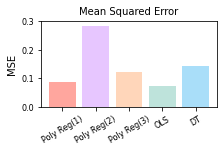

In [41]:
############################ Graph mean squared errors ############################

fig, ax = plt.subplots(figsize=(3,2), constrained_layout=True)

labels = ['Poly Reg(1)','Poly Reg(2)','Poly Reg(3)','OLS','DT']
bar_colors = ['#ffa69e', '#e7c6ff', '#ffd6ba', '#bee3db','#a9def9']
ax.bar(labels, loss_df.loc['all'][0:5], label=labels, color=bar_colors)
ax.set_xticklabels(labels, rotation=30,size=8)
ax.set_title('Mean Squared Error',size=10)
ax.set_ylabel('MSE',size=10)
yticks = [0.0,0.10,0.20,0.30,0.40,0.50]
ax.set_yticklabels(yticks,fontsize=8)
ax.set_ylim(0,0.6)

Ordinary least squares model yields lowest mean squared error and is used in the following code. 

### Create OLS model with ALL test data and evaluate coefficients

In [42]:
############################ Ordinary Least Squares Model with ALL data ############################

model = linear_model.LinearRegression().fit(X,y)
model_coef = pd.DataFrame(model.coef_, index=y.columns, columns=X.columns)
model_coef

,fmax_0,fmax_1,fmax_2,fmax_3,fmax_4,fmax_5,fmax_6,fmax_7,fmax_8,fmax_9,...,skew_5,skew_6,skew_7,skew_8,skew_9,skew_10,skew_11,skew_12,skew_13,skew_14
Hg,0.034813,1.236526,-0.679275,-10.993826,-5.934153,-0.155570,0.009489,-0.011569,3.807306,0.072470,...,-0.151745,-0.074767,-0.090699,-0.065944,0.008524,-0.003140,-0.064455,0.227409,0.032659,0.007539
Pb,0.070605,-0.566483,-1.017054,8.069240,25.608857,0.076806,0.052276,0.109644,0.495331,1.714965,...,0.140560,-0.031026,0.093326,-0.064547,0.091785,-0.125260,-0.002449,0.031516,-0.120236,-0.082382
As,-0.146175,0.482207,-0.013520,-20.676232,7.572158,0.006540,-0.097614,0.043449,3.396327,0.078522,...,-0.086518,-0.022728,-0.002004,0.003581,0.138376,0.131936,0.001272,-0.097673,-0.120845,0.227689
Cd,0.044799,0.589228,2.666203,-15.935038,-11.665283,0.077085,-0.060331,0.168545,-1.855723,2.183850,...,-0.041226,0.016034,0.006115,0.167449,0.256711,0.142952,0.001116,0.088515,0.093937,-0.149283
Cu,-0.097960,-0.724672,0.106213,-6.190361,-1.251507,-0.048565,-0.044126,-0.167353,-1.830195,-1.071231,...,-0.119659,0.090985,-0.075102,0.097077,0.013237,0.084541,0.054994,-0.088570,0.015563,0.021784


In [43]:
######### Change column names to have strain name #########
strains = pd.read_csv('./strains.csv', index_col=0)
col_names = []
feats = {'fmax':'Max','min': 'Min','skew': 'Skew'}
for i in model_coef.columns:
    name = strains.iloc[int(i.split('_')[1])]['Strains']
    col_names.append(name+': '+feats[i.split('_')[0]])
    
model_coef.columns = col_names
model_coef

,merR-ALE2: Max,arsR-ALE2: Max,zntA-ALE1: Max,cadC-ALE3: Max,cadC-ALE1: Max,cusC-ALE3: Max,cusC-ALE2: Max,merR-ALE5: Max,arsR-ALE4: Max,zntA-ALE3: Max,...,cusC-ALE3: Skew,cusC-ALE2: Skew,merR-ALE5: Skew,arsR-ALE4: Skew,zntA-ALE3: Skew,cadC-ALE5: Skew,cusC-ALE5: Skew,merR-ALE4: Skew,arsR-ALE1: Skew,zntA-ALE5: Skew
Hg,0.034813,1.236526,-0.679275,-10.993826,-5.934153,-0.155570,0.009489,-0.011569,3.807306,0.072470,...,-0.151745,-0.074767,-0.090699,-0.065944,0.008524,-0.003140,-0.064455,0.227409,0.032659,0.007539
Pb,0.070605,-0.566483,-1.017054,8.069240,25.608857,0.076806,0.052276,0.109644,0.495331,1.714965,...,0.140560,-0.031026,0.093326,-0.064547,0.091785,-0.125260,-0.002449,0.031516,-0.120236,-0.082382
As,-0.146175,0.482207,-0.013520,-20.676232,7.572158,0.006540,-0.097614,0.043449,3.396327,0.078522,...,-0.086518,-0.022728,-0.002004,0.003581,0.138376,0.131936,0.001272,-0.097673,-0.120845,0.227689
Cd,0.044799,0.589228,2.666203,-15.935038,-11.665283,0.077085,-0.060331,0.168545,-1.855723,2.183850,...,-0.041226,0.016034,0.006115,0.167449,0.256711,0.142952,0.001116,0.088515,0.093937,-0.149283
Cu,-0.097960,-0.724672,0.106213,-6.190361,-1.251507,-0.048565,-0.044126,-0.167353,-1.830195,-1.071231,...,-0.119659,0.090985,-0.075102,0.097077,0.013237,0.084541,0.054994,-0.088570,0.015563,0.021784


(array([0.5, 1.5, 2.5, 3.5, 4.5]),
 [Text(0, 0.5, 'Hg'),
  Text(0, 1.5, 'Pb'),
  Text(0, 2.5, 'As'),
  Text(0, 3.5, 'Cd'),
  Text(0, 4.5, 'Cu')])

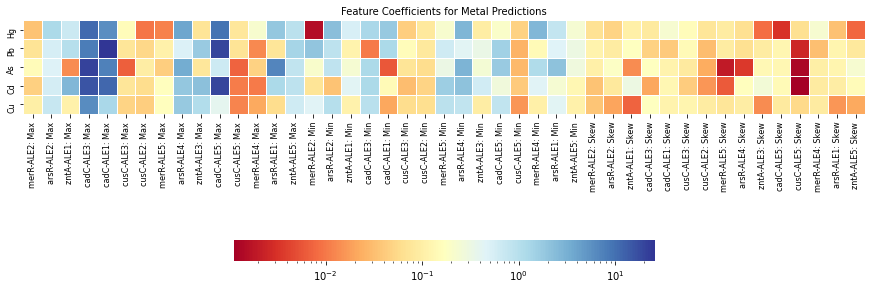

In [44]:
import seaborn as sns
from matplotlib.colors import LogNorm, Normalize

# Plot the heatmap
plt.figure(figsize=(12, 16), constrained_layout=True)
sns.heatmap(model_coef.abs(), norm=LogNorm(), cmap='RdYlBu', linewidths=.5, square=True, cbar_kws={"shrink": 0.5,"orientation": "horizontal"})
plt.title('Feature Coefficients for Metal Predictions', size=10)
plt.xticks(size=8)
plt.yticks(size=8)

### Run model on validation set 

In [97]:
############################ Validation with OLS Model ############################

######### Take in dataframes #########
_pathcsv_fmax = './val/df_fmax.csv'
_pathcsv_min = './val/df_Min.csv'
_pathcsv_skew = './val/df_Skewness.csv'
_pathcsv_conc = './val/conditions_metalconcentrations.csv'

_df_fmax = pd.read_csv(_pathcsv_fmax, header=0, index_col=0)
_df_min = pd.read_csv(_pathcsv_min, header=0, index_col=0)
_df_skew = pd.read_csv(_pathcsv_skew, header=0, index_col=0)
_df_conc = pd.read_csv(_pathcsv_conc, header=0, index_col=0)


######### Standardize #########
_df_fmax_std = val_df_std(df_fmax,_df_fmax)
_df_conc_std = val_df_std_bycol(df_conc,_df_conc)
_df_min_std = val_df_std(df_min,_df_min)
_df_skew_std = val_df_std(df_skew,_df_skew)


######### Concatenate dataframes into 'barcode' #########
HMs = ['Hg', 'Pb', 'As', 'Cd', 'Cu']
strains = list(range(0,15,1))

feats = ['fmax', 'min', 'skew']
_dfs = [_df_fmax_std, _df_min_std, _df_skew_std]


n=0
for i in feats:
    feat_col = []
    for j in strains: 
        feat_col.append(i+'_'+str(j))
    _dfs[n].columns = feat_col 
    n=n+1
    
_X = pd.concat(_dfs, axis=1)
_y = _df_conc_std[0:108]

######### Make error table #########

cols = HMs.copy()
cols.append('all')
_loss_df = pd.DataFrame(index=cols)

In [98]:
## Use model to predict y values  
pred_df = pd.DataFrame(model.predict(_X))
pred_df.columns = _y.columns
pred_df.index = _y.index

## Unstandardize everything and apply mean squared error 
#pred_df = predicted values, y_val = true values
pred_df = val_df_unstd_bycol(df_conc, pred_df)
pred_df = pred_df.clip(lower=0)
y_val = val_df_unstd_bycol(df_conc,_y)


pred_df_copy = pred_df
pred_df_copy = pred_df_copy-y_val
pred_df_copy = pred_df_copy**2
loss_all = pred_df_copy.sum().sum()/pred_df_copy.count().sum()
loss_each = pred_df_copy.sum().values/pred_df_copy.count().values
loss_each = loss_each.tolist()
loss_each.append(loss_all)
_loss_df['VAL'] = loss_each
_loss_df

,VAL
Hg,0.011973
Pb,0.732824
As,0.060576
Cd,0.017540
Cu,0.092618
all,0.183106


In [100]:
# UNCOMMENT TO SAVE AGAIN
# pred_df.to_csv('Predicted.csv')
# y_val.to_csv('True.csv')

/var/folders/r4/n0pt1c0x7ql2s2xvp0l_fsl00000gn/T/ipykernel_33807/1410806877.py:23: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(left=0.25, right=0.95, bottom=0.25, top=0.85)


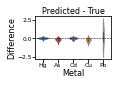

In [101]:
######### Plot differences for each heavy metal in violin plots #########

fig = plt.figure(figsize =(1.5, 1),constrained_layout=True) 

colors = {'Hg':'#317EC2','Pb':'#5AAA46','As':'#C03830','Cd':'#825CA6','Cu':'#E7872B'}
custom_order = ['Hg', 'As', 'Cd', 'Cu', 'Pb']

diff = pred_df - y_val
diff_df = pd.DataFrame(columns=['HM','diff'])
for i in diff.columns: 
    for j in diff[i]:
        diff_df.loc[len(diff_df.index)] = [i,j]

sns.violinplot(data=diff_df, x='HM',y='diff', palette=colors, order=custom_order,linewidth=0.3)
plt.axhline(y=0, color='black', linestyle='--',linewidth=0.5)
plt.title("Predicted - True", size=8, pad=1)
plt.ylabel("Difference",size=8,labelpad=1)
plt.xlabel("Metal",size=8,labelpad=1)
plt.xticks(size=6)
plt.yticks(size=6)
plt.tick_params(axis='x', pad=0)
plt.tick_params(axis='y', pad=0)
plt.subplots_adjust(left=0.25, right=0.95, bottom=0.25, top=0.85)

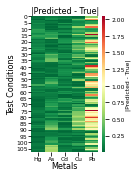

In [102]:
######### Plot heatmap of absolute differences #########

from matplotlib.colors import LinearSegmentedColormap

plt.figure(figsize =(1.5, 2.5))
diff = diff[['Hg', 'As', 'Cd', 'Cu', 'Pb']]
ax = sns.heatmap(data=diff.abs(), cmap='RdYlGn_r',  cbar_kws={'label': '|Predicted - True|'})
ax.figure.axes[-1].yaxis.label.set_size(6)
ax.figure.axes[-1].tick_params(labelsize=6)
ax.figure.axes[-1].yaxis.labelpad = 0
ax.figure.axes[-1].set_aspect(60)
plt.title("|Predicted - True|", size=8, pad=3)
plt.ylabel("Test Conditions",size=8,labelpad=0)
plt.xlabel("Metals",size=8,labelpad=0)
yticks = np.arange(0,108,5)
plt.xticks(size=6, rotation=0)
plt.yticks(size=6, ticks=yticks,labels=yticks, rotation=0)
plt.tick_params(axis='x', pad=0)
plt.tick_params(axis='y', pad=0)

### Single-target WCB benchmark

In [103]:
######### Identify single-target WCBs exhibiting least error #########

singstrain_df = pd.read_csv('./singlestrain.csv',index_col=0) 
strains = pd.read_csv('./strains.csv', index_col=0)

# Separate strains by heavy metal 
hg = []
pb = []
ass = []
cd = []
cu = []
hmstrains = {'merR': hg, 'zntA':pb, 'arsR': ass, 'cadC': cd, 'cusC': cu}
for i in strains['Strains']:
    hm = i.split('-')[0]
    hmstrains[hm].append(i)


# Identify single-target WCBs with least mean squared error 
hm_code = {'merR': 'Hg', 'zntA':'Pb', 'arsR': 'As', 'cadC': 'Cd', 'cusC': 'Cu'}
hms = ['Hg','Pb','As','Cd','Cu']
sensors = ['merR','zntA','arsR','cadC','cusC']

# Compute MSE for each WCB
sing_loss_df = pd.DataFrame(index = singstrain_df.columns)
sing_loss = []

for i in singstrain_df.columns: 
    hm = i.split('-')[0]
    diff = singstrain_df[i] - y_val[hm_code[hm]]
    diff_sq = [number**2 for number in diff]
    diff_sq_sum = sum(diff_sq)
    avg_loss = diff_sq_sum/len(y_val)
    sing_loss.append(avg_loss) 
    
sing_loss_df['avg_loss'] = sing_loss

best_strains = []
for i in sensors:
    best_strains.append(sing_loss_df.loc[hmstrains[i]].idxmin()[0]) 
best_strains

/var/folders/r4/n0pt1c0x7ql2s2xvp0l_fsl00000gn/T/ipykernel_33807/3085561649.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  best_strains.append(sing_loss_df.loc[hmstrains[i]].idxmin()[0])
/var/folders/r4/n0pt1c0x7ql2s2xvp0l_fsl00000gn/T/ipykernel_33807/3085561649.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  best_strains.append(sing_loss_df.loc[hmstrains[i]].idxmin()[0])
/var/folders/r4/n0pt1c0x7ql2s2xvp0l_fsl00000gn/T/ipykernel_33807/3085561649.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent 

['merR-ALE2', 'zntA-ALE5', 'arsR-ALE2', 'cadC-ALE5', 'cusC-ALE3']

/var/folders/r4/n0pt1c0x7ql2s2xvp0l_fsl00000gn/T/ipykernel_33807/1689147522.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(sing_loss_df_copy.index, rotation=45, ha='right', fontname='Helvetica', fontsize=10)


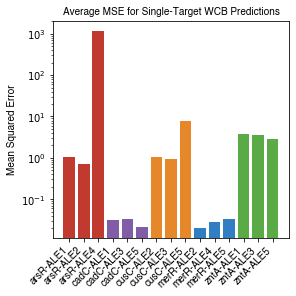

In [104]:
######### Average MSE for single-target WCBs #########

# Map each strain's color 
colors = []
color_map = {'merR':'#317EC2','arsR':'#C03A30','zntA':'#5AAA46','cadC':'#825DA7','cusC':'#E6872A'}

for i in sing_loss_df.index: 
    prefix = i.split('-')[0]
    c = color_map[prefix]
    colors.append(c)
sing_loss_df['color'] = colors
    
# Sort by index so each heavy metal's cognate sensors show up adjacent to one another 
sing_loss_df_copy = sing_loss_df.sort_index()
    
fig, ax = plt.subplots(figsize=(4,4), constrained_layout=True)

# Plot each bar manually to apply individual colors
ax.bar(sing_loss_df_copy.index, sing_loss_df_copy['avg_loss'], color=sing_loss_df_copy['color'])

# Labels and styling
ax.set_title("Average MSE for Single-Target WCB Predictions", fontdict={'fontsize': 10, 'fontname': 'Helvetica'})
ax.set_ylabel("Mean Squared Error", fontdict={'fontsize': 10, 'fontname': 'Helvetica'})
ax.set_xticklabels(sing_loss_df_copy.index, rotation=45, ha='right', fontname='Helvetica', fontsize=10)
ax.tick_params(axis='y', labelsize=10)
plt.yscale('log')

In [105]:
######### Single-target WCB predictions #########

sing_pred = singstrain_df[best_strains]
sing_pred.columns = hms
sing_pred

,Hg,Pb,As,Cd,Cu
1,0.246635,0.208588,1.412609,0.060794,0.547102
2,0.246635,0.257718,1.412609,0.055819,0.598144
3,0.246635,1.961004,1.412609,0.019979,0.548563
4,0.246635,0.243604,1.412609,0.221683,0.370451
5,0.246635,0.244246,1.412609,0.163836,0.376052
...,...,...,...,...,...
104,0.246635,0.000000,0.000000,0.000000,0.000000
105,0.246635,0.000000,0.501029,0.031687,0.000000
106,0.246635,0.000000,0.000000,0.017943,0.000000
107,0.246635,0.000000,0.000000,0.033733,0.000000


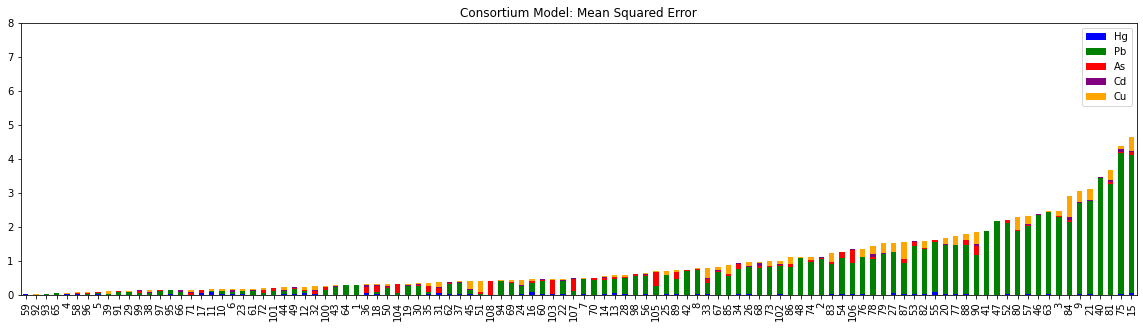

In [106]:
######### Consortium Model MSE for each experimental condition #########
labels = np.array(y_val.columns)
labels_new = np.append(labels,'SUM')
diff_new = pd.DataFrame(columns = labels_new)
stocks = {'Hg':10, 'Pb':100, 'As':10, 'Cd':10, 'Cu':100}

color_map = {
    'Hg': 'blue',
    'Pb': 'green',
    'As': 'red',
    'Cd': 'purple',
    'Cu': 'orange',
}
colors = [color_map[col] for col in hms]


# For each condition (row)
for i in range(1,y_val.shape[0]+1):
    y_add = 0 
    y_sizes = []
    pred_add = 0
    pred_sizes = []
    # For each HM in i condition 
    for j in labels:
        
        y_ppm = y_val[j][i]
        y_sizes.append(y_ppm)
        
        pred_ppm = pred_df[j][i]
        pred_sizes.append(pred_ppm)

    # calculate MSE 
    difference = [y - x for x, y in zip(y_sizes, pred_sizes)]
    diff_sq = [number**2 for number in difference]
    SUM = sum(diff_sq)
    diff_sq.append(SUM)
    diff_new.loc[len(diff_new.index)] = diff_sq

diff_new.index = y_val.index
diff_new.sort_values('SUM',ascending=True)[hms].plot(kind='bar', stacked=True, title='Consortium Model: Mean Squared Error', color=colors, figsize=(20, 5))
plt.ylim(0,8)

ML_df = diff_new
order_loss = diff_new.sort_values('SUM',ascending=True).index

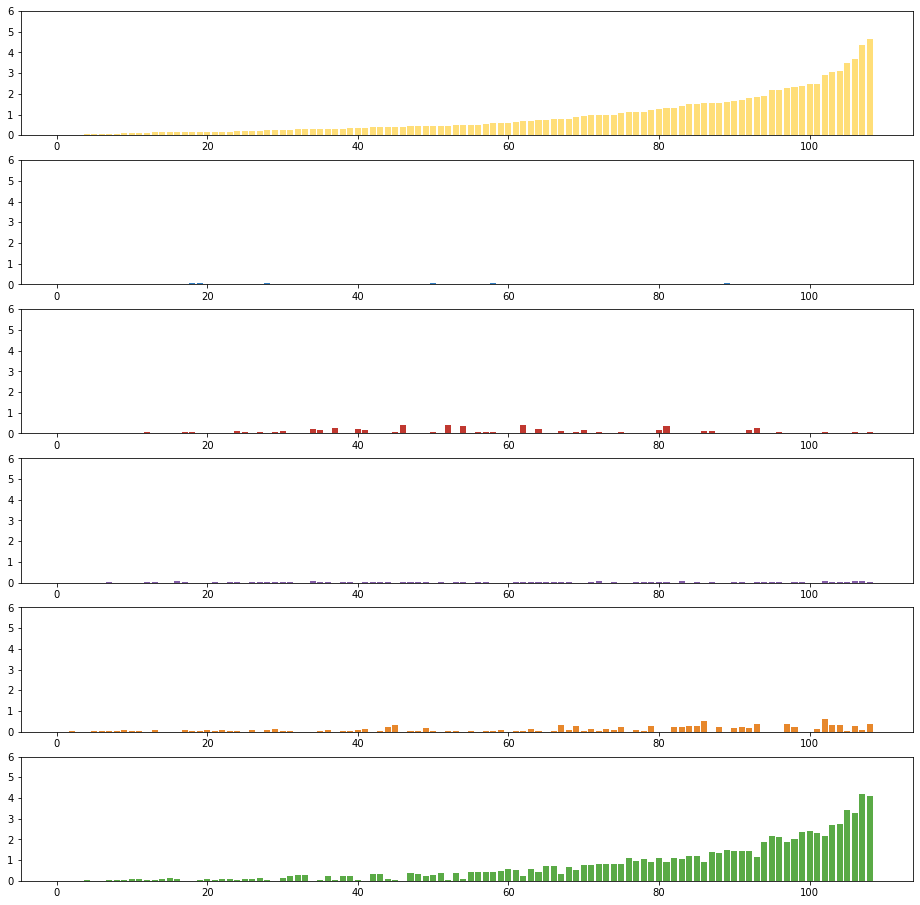

In [107]:
######### Consortium Model MSE Disaggregated into HM Constituents #########

labels = np.array(y_val.columns)
labels_new = np.append(labels,'SUM')
diff_new = pd.DataFrame(columns = labels_new)
#stocks = {'Hg':10, 'Pb':100, 'As':10, 'Cd':10, 'Cu':100}
colors = {'Hg':'#317EC2','Pb':'#5AAA46','As':'#C03830','Cd':'#825CA6','Cu':'#E7872B'}
hms = ['Hg','As','Cd','Cu','Pb']

# For each condition (row)
for i in range(1,y_val.shape[0]+1):
    y_add = 0 
    y_sizes = []
    pred_add = 0
    pred_sizes = []
    # For each HM in i condition 
    for j in labels:
        
        y_ppm = y_val[j][i]
        y_sizes.append(y_ppm)
        
        pred_ppm = pred_df[j][i]
        if pred_ppm < 0:
            pred_ppm = 0
        pred_sizes.append(pred_ppm)
    
    # calculate loss 
    difference = [y - x for x, y in zip(y_sizes, pred_sizes)]
    diff_sq = [number**2 for number in difference]
    SUM = sum(diff_sq)
    diff_sq.append(SUM)
    diff_new.loc[len(diff_new.index)] = diff_sq

diff_new.index = y_val.index
diff_new_re = diff_new.reindex(order_loss) 

fig, axes = plt.subplots(6,1,figsize=(16,16))
ax = axes[0]
ax.bar(diff_new.index, diff_new_re['SUM'],color='#ffde78')
ax.set_ylim(0,6)
axis = 1
for i in hms:
    ax=axes[axis]
    ax.bar(diff_new[i].index, diff_new_re[i],color=colors[i])
    ax.set_ylim(0,6)
    axis=axis+1

(array([ 0.,  5., 10., 15., 20., 25., 30.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

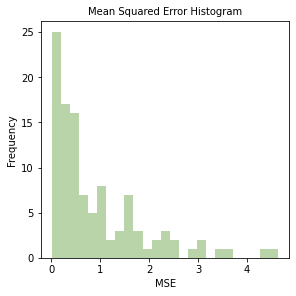

In [108]:
######### MSE Histogram #########


fig = plt.figure(figsize =(4, 4),constrained_layout=True) 
diff_new['SUM'].plot(kind='hist',bins=25, color="#BAD4AA")
plt.title("Mean Squared Error Histogram",size=10)
plt.xlabel("MSE",size=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

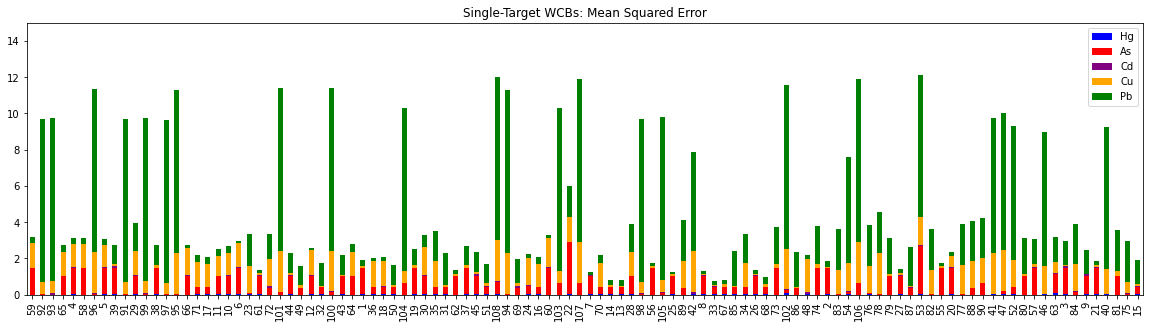

In [109]:
######### Single-Target WCB MSE for each experimental condition #########
labels = np.array(y_val.columns)
labels_new = np.append(labels,'SUM')
diff_new = pd.DataFrame(columns = labels_new)
#stocks = {'Hg':10, 'Pb':100, 'As':10, 'Cd':10, 'Cu':100}

color_map = {
    'Hg': 'blue',
    'Pb': 'green',
    'As': 'red',
    'Cd': 'purple',
    'Cu': 'orange',
}
colors = [color_map[col] for col in hms]

# For each condition (row)
for i in range(1,y_val.shape[0]+1):
    y_add = 0 
    y_sizes = []
    pred_add = 0
    pred_sizes = []
    # For each HM in i condition 
    for j in labels:
        
        y_ppm = y_val[j][i]
        y_sizes.append(y_ppm)
        
        pred_ppm = sing_pred[j][i]
        pred_sizes.append(pred_ppm)
    
    # Calculate MSE 
    difference = [y - x for x, y in zip(y_sizes, pred_sizes)]
    diff_sq = [number**2 for number in difference]
    SUM = sum(diff_sq)
    diff_sq.append(SUM)
    diff_new.loc[len(diff_new.index)] = diff_sq

diff_new.index = y_val.index
diff_new_re = diff_new.reindex(order_loss)
diff_new_re[hms].plot(kind='bar', stacked=True, title='Single-Target WCBs: Mean Squared Error', color=colors, figsize=(20, 5))
plt.ylim(0,15)
plt.legend(loc='upper right')

SING_df = diff_new

93.51851851851852%


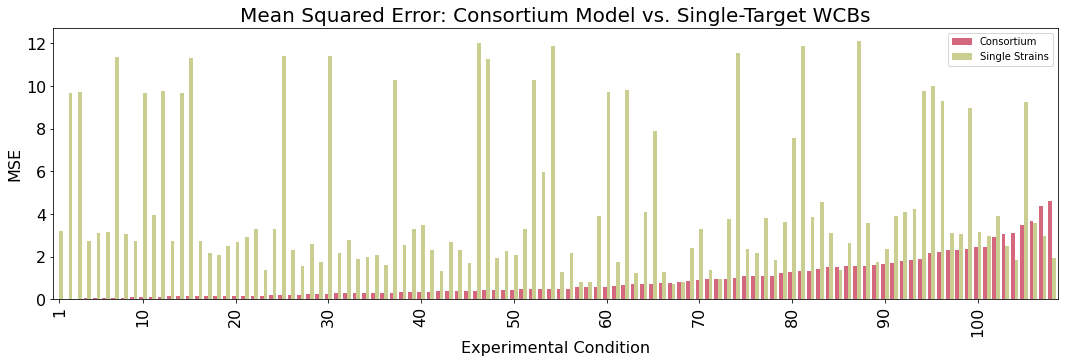

In [110]:
######### Consortium Model v. Single-Target WCBs #########

MLvSING_df = pd.DataFrame(index = ML_df.index)
MLvSING_df['ML'] = ML_df['SUM']
MLvSING_df['SING'] = SING_df['SUM']
MLvSING_df_re = MLvSING_df.reindex(order_loss)
MLvSING_df_re.index=MLvSING_df.index
colors = ["#d3687f","#CBCE91"]
MLvSING_df_re.plot(kind="bar", figsize=(18,5), color=colors, width=0.8)
plt.title("Mean Squared Error: Consortium Model vs. Single-Target WCBs", fontsize=20)
plt.legend(["Consortium","Single Strains"])
xticks = [0,9,19,29,39,49,59,69,79,89,99]
plt.xticks(xticks, fontsize=16)
yticks = [0,2,4,6,8,10,12]
plt.yticks(yticks, fontsize=16)
plt.xlabel('Experimental Condition', fontsize=16)
plt.ylabel('MSE', fontsize=16)

count = 0
for i in MLvSING_df.index:
    if MLvSING_df['ML'].iloc[i-1] <= MLvSING_df['SING'].iloc[i-1]:
        count=count+1
print(str(count/len(MLvSING_df)*100)+"%")

In [111]:
worst10 = order_loss[-10:]
worst10_df = y_val.loc[worst10]
worst10_df.index = [99,100,101,102,103,104,105,106,107,108]
worst10_df

,Hg,Pb,As,Cd,Cu
99,0.08,3.0,0.4,0.04,1.5
100,0.30,0.8,0.4,0.30,0.8
101,0.08,0.8,0.2,0.30,0.8
102,0.30,1.5,0.4,0.30,1.5
103,0.08,0.8,0.4,0.30,0.8
104,0.08,1.5,0.2,0.30,0.8
105,0.08,3.0,0.2,0.04,1.5
106,0.30,1.5,0.4,0.30,0.8
107,0.30,1.5,0.2,0.30,0.8
108,0.08,0.8,0.8,0.30,0.8


In [112]:
best10 = order_loss[:10]
best10_df = y_val.loc[best10]
best10_df.index = [1,2,3,4,5,6,7,8,9,10]
best10_df

,Hg,Pb,As,Cd,Cu
1,0.30,0.8,0.2,0.08,1.5
2,0.30,3.0,0.2,0.08,0.8
3,0.30,3.0,0.2,0.30,0.8
4,0.30,0.8,0.4,0.08,1.5
5,0.08,0.8,0.2,0.04,1.5
6,0.30,0.8,0.2,0.04,1.5
7,0.30,3.0,0.2,0.30,1.5
8,0.08,0.8,0.2,0.08,1.5
9,0.08,3.0,0.2,0.30,0.8
10,0.30,3.0,0.2,0.04,0.8


/var/folders/r4/n0pt1c0x7ql2s2xvp0l_fsl00000gn/T/ipykernel_33807/3951999497.py:41: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(0,100)
/var/folders/r4/n0pt1c0x7ql2s2xvp0l_fsl00000gn/T/ipykernel_33807/3951999497.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([""])


[Text(-0.5, 0, ''),
 Text(0.0, 0, ''),
 Text(0.5, 0, ''),
 Text(1.0, 0, ''),
 Text(1.5, 0, '')]

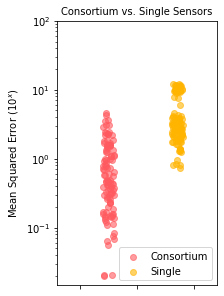

In [113]:
######### Consortium Model v. Single-Target WCBs MSE Scatterplot #########

import ptitprince as pt

comp_diff = pd.DataFrame(columns = ['method','diff'])
for i in MLvSING_df['ML']:
    comp_diff.loc[len(comp_diff)] = ['ML',i]
for j in MLvSING_df['SING']:
    comp_diff.loc[len(comp_diff)] = ['SING',j]
comp_diff

COLORS = ["#FF5A5F", '#FFB400', ]


# Create our own Axes with custom size
fig, ax = plt.subplots(figsize=(3, 4), constrained_layout=True)

SPECIES = ['ML', 'SING']

# Iterate over the species
for i, species in enumerate(SPECIES):
    # Subset the data
    data = comp_diff[comp_diff['method'] == species]
    
    # Jitter the values on the vertical axis
    if i == 0:
        x = i + np.random.uniform(high=0.1, size=len(data))+0.2
    elif i == 1:
        x = i + np.random.uniform(high=0.1, size=len(data))-0.2
    
    # Select the values of the horizontal axis
    y = data["diff"]
    
    # Add the rain using the scatter method.
    ax.scatter(x, y, color=COLORS[i], alpha=0.6)
    
ax.set_title("Consortium vs. Single Sensors", size=10)
ax.set_xlabel("")
ax.set_ylabel("Mean Squared Error (10$^x$)", size=10)
ax.set_yscale('log')
ax.set_ylim(0,100)
ax.legend(['Consortium','Single'], loc='lower right', fontsize=10)
ax.set_xlim(-0.2,1.2)
ax.set_xticklabels([""])

Difference: 64.81481481481481%


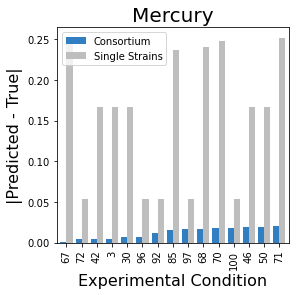

In [137]:
fig, ax = plt.subplots(1,1, figsize=(4, 4), facecolor='white', constrained_layout=True)

Hg_order = ML_df.sort_values('Hg',ascending=True).index
Hg_MLvSING = pd.DataFrame(index = Hg_order)
colors = ["#317EC2","#BEBEBE"]

### TOP 10 ABSOLUTE DIFFERENCE 
sing_comp = abs(sing_pred - y_val)
pred_comp = abs(pred_df - y_val) 
Hg_MLvSING['ML_diff'] = pred_comp.loc[Hg_order]['Hg']
Hg_MLvSING['SING_diff'] = sing_comp.loc[Hg_order]['Hg']


### PLOT DIFF
Hg_MLvSING[['ML_diff','SING_diff']][0:15].plot(kind="bar", color=colors, width=0.8,ax=ax)
ax.set_title("Mercury", fontsize=20)
ax.legend(["Consortium","Single Strains"],loc='upper left')
ax.set_xlabel('Experimental Condition', fontsize=16)
ax.set_ylabel('|Predicted - True|', fontsize=16)

count = 0
for i in Hg_MLvSING.index:
    if Hg_MLvSING['ML_diff'].iloc[i-1] <= Hg_MLvSING['SING_diff'].iloc[i-1]:
        count=count+1
print('Difference: '+str(count/len(Hg_MLvSING)*100)+"%")


Difference: 75.92592592592592%


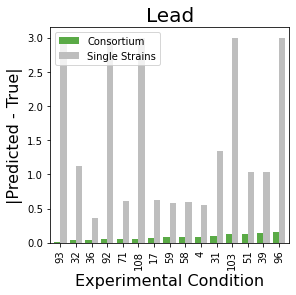

In [138]:
fig, ax = plt.subplots(1,1, figsize=(4, 4), facecolor='white', constrained_layout=True)

Pb_order = ML_df.sort_values('Pb',ascending=True).index
Pb_MLvSING = pd.DataFrame(index = Pb_order)
colors = ["#5AAA46","#BEBEBE"]

### TOP 10 ABSOLUTE DIFFERENCE 
sing_comp = abs(sing_pred - y_val)
pred_comp = abs(pred_df - y_val) 
Pb_MLvSING['ML_diff'] = pred_comp.loc[Pb_order]['Pb']
Pb_MLvSING['SING_diff'] = sing_comp.loc[Pb_order]['Pb']


### PLOT DIFF
Pb_MLvSING[['ML_diff','SING_diff']][0:15].plot(kind="bar",color=colors, width=0.8,ax=ax)
ax.set_title("Lead", fontsize=20)
ax.legend(["Consortium","Single Strains"],loc='upper left')
ax.set_xlabel('Experimental Condition', fontsize=16)
ax.set_ylabel('|Predicted - True|', fontsize=16)


count = 0
for i in Pb_MLvSING.index:
    if Pb_MLvSING['ML_diff'].iloc[i-1] <= Pb_MLvSING['SING_diff'].iloc[i-1]:
        count=count+1
print('Difference: '+str(count/len(Pb_MLvSING)*100)+"%")


Difference: 92.5925925925926%


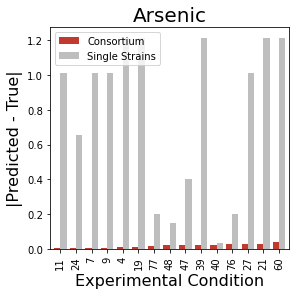

In [139]:
fig, ax = plt.subplots(1,1, figsize=(4, 4), facecolor='white', constrained_layout=True)

As_order = ML_df.sort_values('As',ascending=True).index
As_MLvSING = pd.DataFrame(index = As_order)
colors = ["#C03A30","#BEBEBE"]

### TOP 10 ABSOLUTE DIFFERENCE 
sing_comp = abs(sing_pred - y_val)
pred_comp = abs(pred_df - y_val) 
As_MLvSING['ML_diff'] = pred_comp.loc[As_order]['As']
As_MLvSING['SING_diff'] = sing_comp.loc[As_order]['As']


### PLOT DIFF
As_MLvSING[['ML_diff','SING_diff']][0:15].plot(kind="bar",color=colors, width=0.8,ax=ax)
ax.set_title("Arsenic", fontsize=20)
ax.legend(["Consortium","Single Strains"],loc='upper left')
ax.set_xlabel('Experimental Condition', fontsize=16)
ax.set_ylabel('|Predicted - True|', fontsize=16)


count = 0
for i in As_MLvSING.index:
    if As_MLvSING['ML_diff'].iloc[i-1] <= As_MLvSING['SING_diff'].iloc[i-1]:
        count=count+1
print('Difference: '+str(count/len(As_MLvSING)*100)+"%")


Difference: 49.074074074074076%


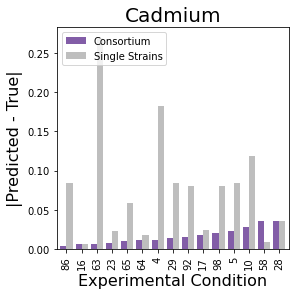

In [140]:
fig, ax = plt.subplots(1,1, figsize=(4, 4), facecolor='white', constrained_layout=True)

Cd_order = ML_df.sort_values('Cd',ascending=True).index
Cd_MLvSING = pd.DataFrame(index = Cd_order)
colors = ["#825DA7","#BEBEBE"]

### TOP 10 ABSOLUTE DIFFERENCE 
sing_comp = abs(sing_pred - y_val)
pred_comp = abs(pred_df - y_val) 
Cd_MLvSING['ML_diff'] = pred_comp.loc[Cd_order]['Cd']
Cd_MLvSING['SING_diff'] = sing_comp.loc[Cd_order]['Cd']


### PLOT DIFF
Cd_MLvSING[['ML_diff','SING_diff']][0:15].plot(kind="bar", color=colors, width=0.8,ax=ax)
ax.set_title("Cadmium", fontsize=20)
ax.legend(["Consortium","Single Strains"],loc='upper left')
ax.set_xlabel('Experimental Condition', fontsize=16)
ax.set_ylabel('|Predicted - True|', fontsize=16)


count = 0
for i in Cd_MLvSING.index:
    if Cd_MLvSING['ML_diff'].iloc[i-1] <= Cd_MLvSING['SING_diff'].iloc[i-1]:
        count=count+1
print('Difference: '+str(count/len(Cd_MLvSING)*100)+"%")



Difference: 82.4074074074074%


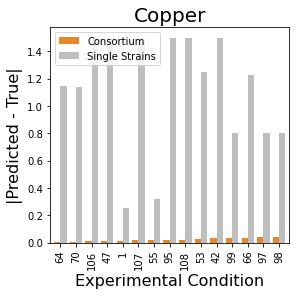

In [141]:
fig, ax = plt.subplots(1,1, figsize=(4, 4), facecolor='white', constrained_layout=True)

Cu_order = ML_df.sort_values('Cu',ascending=True).index
Cu_MLvSING = pd.DataFrame(index = Cu_order)
colors = ["#E6872A","#BEBEBE"]

### TOP 10 ABSOLUTE DIFFERENCE 
sing_comp = abs(sing_pred - y_val)
pred_comp = abs(pred_df - y_val) 
Cu_MLvSING['ML_diff'] = pred_comp.loc[Cu_order]['Cu']
Cu_MLvSING['SING_diff'] = sing_comp.loc[Cu_order]['Cu']


### PLOT DIFF
Cu_MLvSING[['ML_diff','SING_diff']][0:15].plot(kind="bar", color=colors, width=0.8,ax=ax)
ax.set_title("Copper", fontsize=20)
ax.legend(["Consortium","Single Strains"],loc='upper left')
ax.set_xlabel('Experimental Condition', fontsize=16)
ax.set_ylabel('|Predicted - True|', fontsize=16)


count = 0
for i in Cu_MLvSING.index:
    if Cu_MLvSING['ML_diff'].iloc[i-1] <= Cu_MLvSING['SING_diff'].iloc[i-1]:
        count=count+1
print('Difference: '+str(count/len(Cu_MLvSING)*100)+"%")


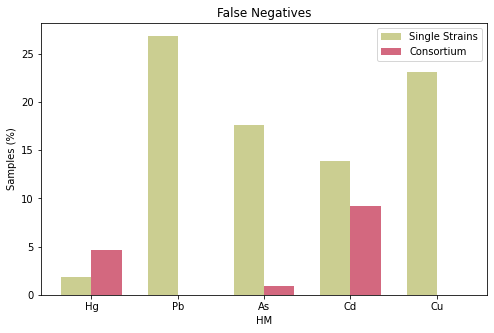

In [134]:
FNs_df = pd.DataFrame(columns=['SING','ML','HM'])

for i in y_val.columns:
    filtered_sing = sing_pred[sing_pred[i] <= 0]
    FN_sing = (len(filtered_sing)/len(sing_pred[i]))*100
    filtered_ML = pred_df[pred_df[i] <= 0]
    FN_ML = (len(filtered_ML)/len(pred_df[i]))*100    
    FNs_df.loc[len(FNs_df)] = [FN_sing,FN_ML,i]

# Define x-axis positions
x = np.arange(len(FNs_df['HM']))  # HM categories
width = 0.35  # Bar width

# Create figure and axes
fig, ax = plt.subplots(figsize=(8, 5))

# Plot bars
bars1 = ax.bar(x - width/2, FNs_df['SING'], width, label='Single Strains',color='#CBCE91')
bars2 = ax.bar(x + width/2, FNs_df['ML'], width, label='Consortium',color='#d3687f')

# Labels, Title, and Ticks
ax.set_xlabel("HM")
ax.set_ylabel("Samples (%)")
ax.set_title("False Negatives")
ax.set_xticks(x)
ax.set_xticklabels(FNs_df['HM'])  # Set HM names as x-axis labels
ax.legend()


Overall RMSE: 0.4279

Per-metal RMSE:
Hg: 0.1094
Pb: 0.8561
As: 0.2461
Cd: 0.1324
Cu: 0.3043


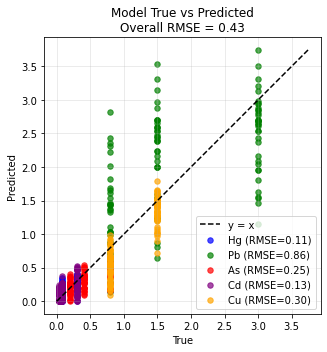

In [135]:
# ---- overall RMSE ----
y_true_all = y_val.values.flatten()
y_pred_all = pred_df.values.flatten()

overall_rmse = np.sqrt(mean_squared_error(y_true_all, y_pred_all))
print(f"Overall RMSE: {overall_rmse:.4f}")

# ---- per-metal RMSE ----
per_metal_rmse = {}

for col in y_val.columns:
    per_metal_rmse[col] = np.sqrt(mean_squared_error(y_val[col], pred_df[col]))

print("\nPer-metal RMSE:")
for metal, rmse in per_metal_rmse.items():
    print(f"{metal}: {rmse:.4f}")

# ---- plotting true vs pred with per-metal colors ----
color_map = {'Hg':'blue','Pb':'green','As':'red','Cd':'purple','Cu':'orange'}

plt.figure(figsize=(5,5))

# scatter each metal
for hm in y_val.columns:
    plt.scatter(
        y_val[hm],
        pred_df[hm],
        label=f"{hm} (RMSE={per_metal_rmse[hm]:.2f})",
        color=color_map.get(hm, 'gray'),
        alpha=0.7,
        s=30
    )

# perfect line y=x
minval = min(y_true_all.min(), y_pred_all.min())
maxval = max(y_true_all.max(), y_pred_all.max())
plt.plot([minval, maxval], [minval, maxval], '--', color='black', label='y = x')

plt.xlabel('True')
plt.ylabel('Predicted')
plt.title(f"Model True vs Predicted\nOverall RMSE = {overall_rmse:.2f}")
plt.legend()
plt.grid(alpha=0.3)
plt.axis('square')
plt.tight_layout()
plt.show()


Overall RMSE: 0.9436

Per-metal RMSE:
Hg: 0.1422
Pb: 1.6699
As: 0.8369
Cd: 0.1469
Cu: 0.9599


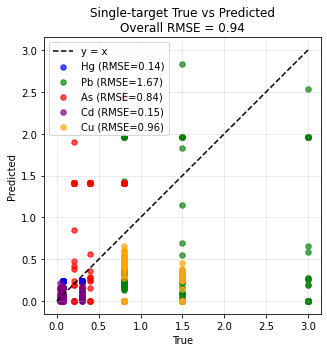

In [136]:
# ---- overall RMSE ----
y_true_all = y_val.values.flatten()
y_pred_all = sing_pred.values.flatten()

overall_rmse = np.sqrt(mean_squared_error(y_true_all, y_pred_all))
print(f"Overall RMSE: {overall_rmse:.4f}")

# ---- per-metal RMSE ----
per_metal_rmse = {}

for col in y_val.columns:
    per_metal_rmse[col] = np.sqrt(mean_squared_error(y_val[col], sing_pred[col]))

print("\nPer-metal RMSE:")
for metal, rmse in per_metal_rmse.items():
    print(f"{metal}: {rmse:.4f}")

# ---- plotting true vs pred with per-metal colors ----
color_map = {'Hg':'blue','Pb':'green','As':'red','Cd':'purple','Cu':'orange'}

plt.figure(figsize=(5,5))

# scatter each metal
for hm in y_val.columns:
    plt.scatter(
        y_val[hm],
        sing_pred[hm],
        label=f"{hm} (RMSE={per_metal_rmse[hm]:.2f})",
        color=color_map.get(hm, 'gray'),
        alpha=0.7,
        s=30
    )

# perfect line y=x
minval = min(y_true_all.min(), y_pred_all.min())
maxval = max(y_true_all.max(), y_pred_all.max())
plt.plot([minval, maxval], [minval, maxval], '--', color='black', label='y = x')

plt.xlabel('True')
plt.ylabel('Predicted')
plt.title(f"Single-target True vs Predicted\nOverall RMSE = {overall_rmse:.2f}")
plt.legend()
plt.grid(alpha=0.3)
plt.axis('square')
plt.tight_layout()
plt.show()
